# K-mean clustering of 5x5 image patches of MNIST dataset 

MNIST dataset contains 28x28 hand-written digits. Please extract 5x5 patches from 28x28 images, and there are more than 20 million such image patches. Of course, a majority of these image patches will be blank. You can discard these blank patches and focus on the rest ones, and do a K-mean clustering with these small image patches.

Please analyze the change of the learned clusters when you increase K from 100 – 10,000 (or even more). You can also analyze how well you can reconstruct a 5x5 MNIST patch by your learned dictionary (clusters). There are some interesting questions: 1) How many clusters do you need in order to cover the whole patch space? What are these clusters and do they have any interpretable meanings? How is one digit made from these clusters? These questions are just some example questions, and you are in charge of what is interesting to you in this weird image patch space.

 

One useful trick in this experiment may be that you can normalize your patch vector to unit norm, then your clusters can also be normalized, and the Euclidean distance is equivalent to sqrt(2-2<feature vector, image patch vector>). Of course, this will create issue with all blank patch, which needs additional care.

 

If you have a group, each one in the group can submit the same report. When you submit the report, please acknowledge the detail contribution from each member. 

In [1]:
import joblib
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import torchvision.datasets as datasets
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors


## Download MNIST

In [2]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist = mnist_testset + mnist_trainset

## Split data into patches and save

In [3]:
def patch_data(dataset):
    # split into patches
    patches = []
    patch_size = 5
    img_size = 28
    for img, label in tqdm(dataset):
        img = np.array(img)
        for i in range(img_size - patch_size + 1):
            for j in range(img_size - patch_size + 1):
                patch = img[i:i+patch_size, j:j+patch_size]
                if not (patch == 0).all():
                    patches.append(patch)
    return np.array(patches)

In [19]:
patches = patch_data(mnist)
np.save('./data/patches.npy', patches)

100%|██████████| 70000/70000 [01:05<00:00, 1064.09it/s]


In [4]:
patches = np.load('./data/patches.npy')

## Visualize some example patches

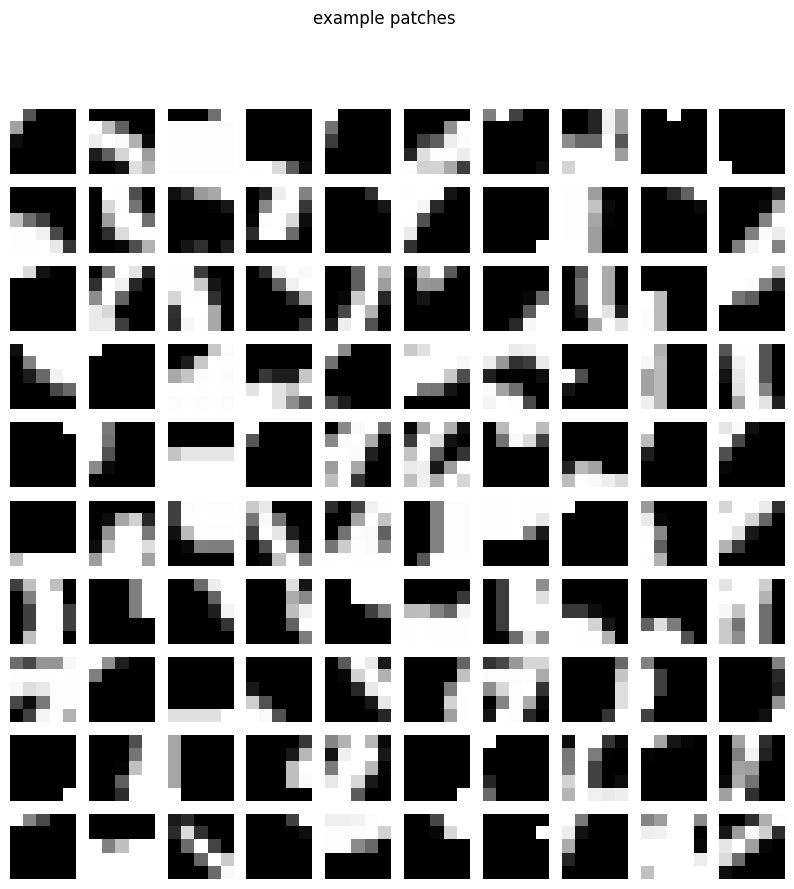

In [5]:
# Visualize some patches
rng = np.random.default_rng(seed=30)
sample_patch_idx = rng.integers(low=0, high=patches.shape[0], size=100)
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(sample_patch_idx.shape[0]):
    ax = axes[i//10, i%10]
    ax.imshow(patches[sample_patch_idx[i]], cmap='grey')
    ax.axis('off')
plt.suptitle('example patches')
plt.show()

## Center, whiten, and normalize patches

In [6]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preprocess_patches(patches: np.ndarray):
    
    # flatten patches to (N,25)
    patch_vectors = patches.reshape(patches.shape[0], -1)

    # subtract mean from patches
    mean = np.mean(patch_vectors, axis=0)
    patch_vectors = patch_vectors - mean
    
    # whiten patches
    #pca = PCA(whiten=True)
    #patch_vectors = pca.fit_transform(patch_vectors)   
    zcaMatrix = zca_whitening_matrix(patch_vectors.T)
    patch_vectors = np.dot(zcaMatrix, patch_vectors.T) # project X onto the ZCAMatrix
    patch_vectors = patch_vectors.T

    # normalize patches
    patch_vectors = normalize(patch_vectors, norm='l2')
    
    return patch_vectors, mean, zcaMatrix

In [7]:
whitened_patches, mean, whitening_matrix = preprocess_patches(patches)

## Visualize pre-processed patches

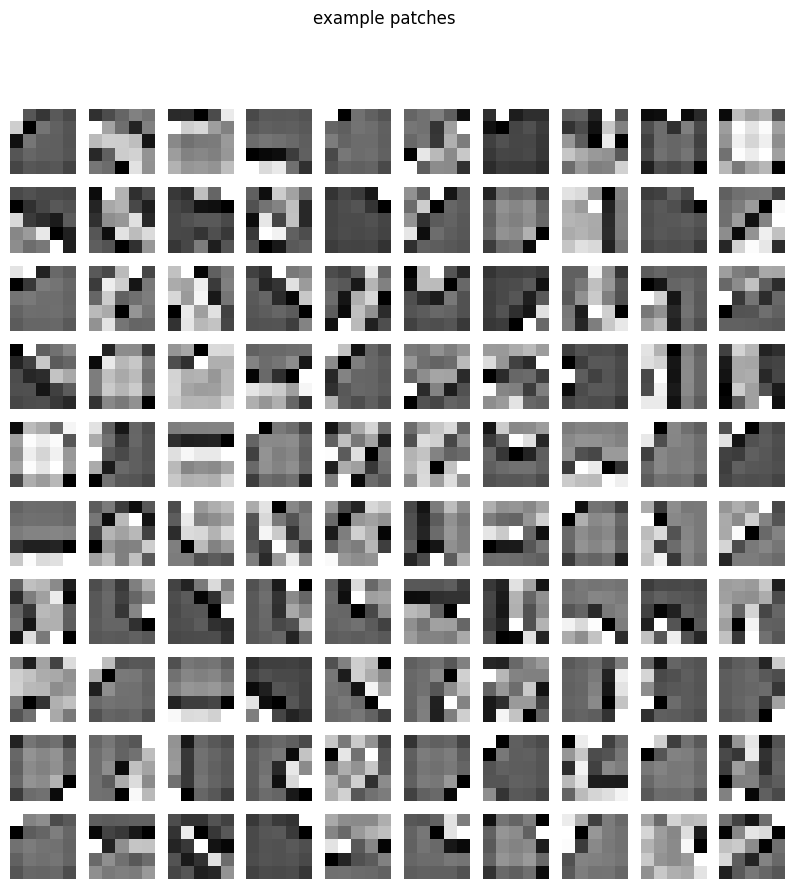

In [8]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(sample_patch_idx.shape[0]):
    ax = axes[i//10, i%10]
    ax.imshow(whitened_patches[sample_patch_idx[i]].reshape(5, 5), cmap='grey')
    ax.axis('off')
plt.suptitle('example patches')
plt.show()

## Apply K-means from 100 to 10000 clusters

In [8]:
def apply_kmeans_to_patches(patches, n_clusters=100, sample_size=1000000):
    """
    Apply k-means clustering to 5x5 image patches.
    
    Args:
        patches: torch tensor of shape (N, 5, 5) where N is number of patches
        n_clusters: number of clusters (K)
        normalize_patches: whether to normalize patches to unit norm
        sample_size: if not None, randomly sample this many patches for clustering
    
    Returns:
        kmeans: fitted KMeans object
        cluster_centers: cluster centers reshaped back to (n_clusters, 5, 5)
    """
    if sample_size is not None and sample_size < len(patches):
        # Randomly sample patches
        indices = np.random.choice(len(patches), sample_size, replace=False)
        patches = patches[indices]
    
    # Apply k-means
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=43, n_init=10)
    kmeans.fit(patches)
    return kmeans

In [10]:
n_clusters = np.concat((np.array([100]),np.arange(1000,11000,1000)))

In [ ]:
for i in tqdm(n_clusters):
    kmeans = apply_kmeans_to_patches(whitened_patches, i, sample_size=None)
    joblib.dump(kmeans, f"kmeans_{i}.pkl")
    del kmeans

100%|██████████| 11/11 [44:26<00:00, 242.45s/it]


In [156]:
for i in tqdm(n_clusters):
    kmeans = joblib.load(f'./kmeans_{i}.pkl')
    prediction = kmeans.predict(whitened_patches)
    np.save(f"./prediction_{i}", prediction)

100%|██████████| 11/11 [05:32<00:00, 30.25s/it]


## Calculate MSE on predictions for all patches across cluster size

In [ ]:
mses = []
for i in tqdm(n_clusters):
    kmeans = joblib.load(f'./kmeans_{i}.pkl')
    prediction = np.load(f"./prediction_{i}.npy")
    mse = 0
    for j in range(whitened_patches.shape[0]):
        cluster = kmeans.cluster_centers_[prediction[j]]
        mse += np.linalg.norm(cluster - whitened_patches[j])
    mses.append(mse/whitened_patches.shape[0])
np.save("./mses.npy", np.array(mses))

100%|██████████| 11/11 [05:14<00:00, 28.55s/it]


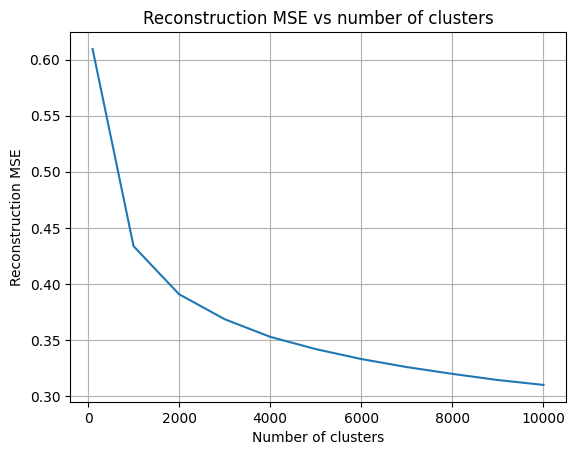

In [11]:
mses = np.load("./mses.npy")

plt.figure()
plt.grid()
plt.title("Reconstruction MSE vs number of clusters")
plt.ylabel("Reconstruction MSE")
plt.xlabel("Number of clusters")
plt.plot(n_clusters, mses)

## Visualize clusters for the sample patches from above

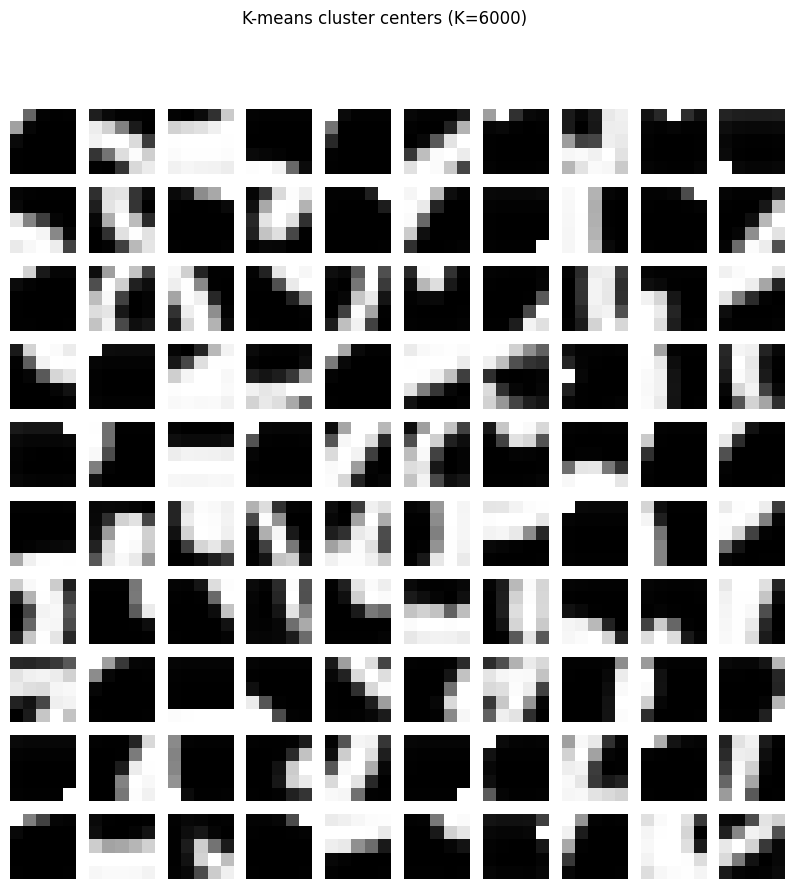

In [12]:
k = 6000
kmeans = joblib.load(f'./kmeans_{k}.pkl')
prediction = np.load(f"./prediction_{k}.npy")
centers = kmeans.cluster_centers_

# Visualize cluster centers for our chosen patches
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(sample_patch_idx.shape[0]):
    # unwhiten and then reshape cluster
    cluster = np.dot(np.linalg.inv(whitening_matrix), centers[prediction[sample_patch_idx[i]]]).reshape(5, 5)
    ax = axes[i//10, i%10]
    ax.imshow(cluster, cmap='grey')
    ax.axis('off')
plt.suptitle(f'K-means cluster centers (K={k})')
plt.show()

## Visualize Clusters with the most patches assigned to them

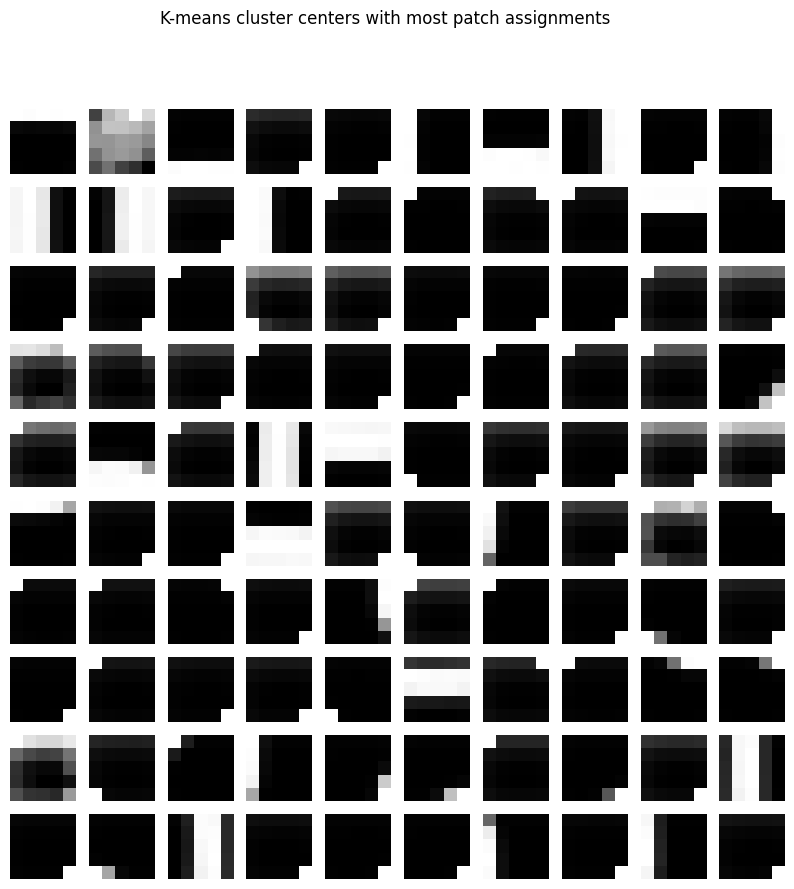

In [13]:
i = 10000
kmeans = joblib.load(f'./kmeans_{i}.pkl')
prediction = np.load(f"./prediction_{i}.npy")
centers = kmeans.cluster_centers_
hist, bins = np.histogram(prediction, bins=i, range=None, density=False, weights=None)

sorting_indices = np.argsort(hist)[::-1]

# Use the sorting indices to reorder 'array_to_sort'
sorted_centers = centers[sorting_indices]

#Visualize cluster centers with most patch assignments
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    # unwhiten and then reshape cluster
    cluster = np.dot(np.linalg.inv(whitening_matrix), sorted_centers[i]).reshape(5, 5)
    ax = axes[i//10, i%10]
    ax.imshow(cluster, cmap='grey')
    ax.axis('off')
plt.suptitle('K-means cluster centers with most patch assignments')
plt.show()

## Reconstruct a number

100%|██████████| 24/24 [00:00<00:00, 53687.09it/s]


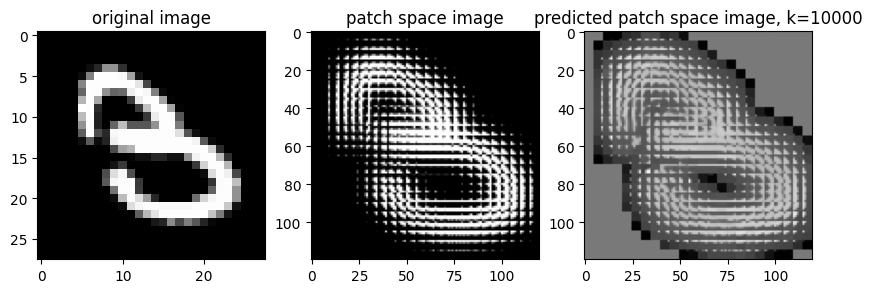

In [14]:
k = 10000
kmeans = joblib.load(f'./kmeans_{k}.pkl')
prediction = np.load(f"./prediction_{k}.npy")

patch_cols = []
predicted_cols = []
patch_size = 5
img_size = 28
img, label = mnist[18]
img = np.array(img)
for i in tqdm(range(img_size - patch_size + 1)):
    patch_col = []
    predicted_col = []
    for j in range(img_size - patch_size + 1):
        patch = img[i:i+patch_size, j:j+patch_size]
        patch_col.append(patch)

        if not (patch == 0).all():
            whitened_patch = normalize(np.dot(whitening_matrix, (patch.reshape(-1) - mean)).reshape(1, -1), norm='l2')
            cluster = kmeans.cluster_centers_[kmeans.predict(whitened_patch)]
            cluster = np.dot(np.linalg.inv(whitening_matrix), cluster.flatten()).reshape(5,5)
            predicted_col.append(cluster)
        else:
            predicted_col.append(patch)
    patch_cols.append(patch_col)
    predicted_cols.append(predicted_col)


for i, patch_col in enumerate(tqdm(patch_cols)):
    col = np.concat(patch_col, axis=1)
    patch_cols[i] = col

    predicted_col = np.concat(predicted_cols[i], axis=1)
    predicted_cols[i] = predicted_col

big_img = np.concat(patch_cols, axis=0)
big_predict = np.concat(predicted_cols, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(img, cmap="grey")
axes[0].set_title("original image")

axes[1].imshow(big_img, cmap="grey")
axes[1].set_title("patch space image")

axes[2].imshow(big_predict,cmap="grey")
axes[2].set_title(f"predicted patch space image, k={k}")
plt.show()

## Visualize KNN for random patches

In [15]:
nbrs = NearestNeighbors(n_neighbors=10).fit(whitened_patches)

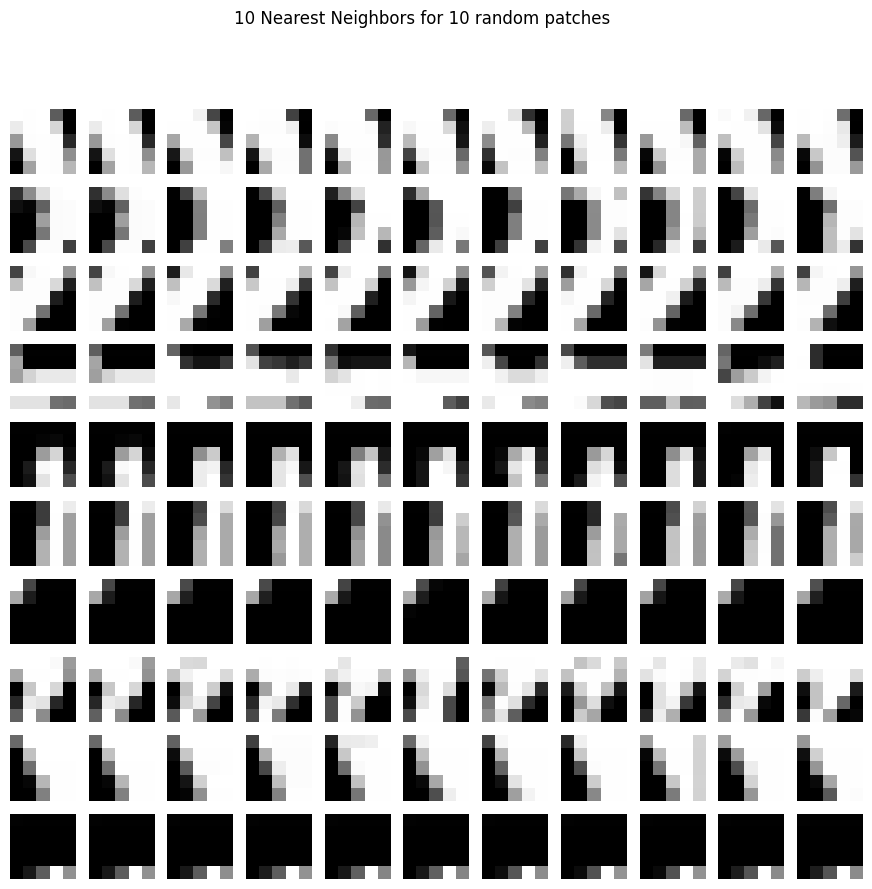

In [199]:
fig, axes = plt.subplots(10, 11, figsize=(11, 10))
sample_patch_idx = rng.integers(low=0, high=whitened_patches.shape[0], size=10)
for i in range(sample_patch_idx.shape[0]):
    # unwhiten and then reshape cluster
    sample_patch = np.dot(np.linalg.inv(whitening_matrix), whitened_patches[sample_patch_idx[i]]).reshape(5, 5)
    ax = axes[i, 0]
    ax.imshow(sample_patch, cmap='grey')
    ax.axis('off')

    distances, indices = nbrs.kneighbors(whitened_patches[sample_patch_idx[i]].reshape(1,-1))
    indices = indices.flatten()
    for j, nbr in enumerate(indices):
        sample_patch = np.dot(np.linalg.inv(whitening_matrix), whitened_patches[indices[j]]).reshape(5, 5)
        ax = axes[i, j+1]
        ax.imshow(sample_patch, cmap='grey')
        ax.axis('off')
plt.suptitle('10 Nearest Neighbors for 10 random patches')
plt.show()

## Sparse Manifold Transform

In [16]:
k = 10000
kmeans = joblib.load(f'./kmeans_{k}.pkl')
prediction = np.load(f"./prediction_{k}.npy")

A = np.zeros((k,prediction.shape[0]))
for i in tqdm(range(prediction.shape[0])):
    A[prediction[i], i] = 1


 68%|██████▊   | 16010152/23426010 [00:31<00:13, 541270.07it/s]

: 